## **Stage 1: Importing Data and Creating the DataFrame**
### **Cell 1**  
**Description**:  
- **`pandas`**: For handling and manipulating tabular data.  
- **`datetime`**: For date and time operations required for calculating recency in RFM analysis. 
 

```python

In [97]:
import pandas as pd
from datetime import datetime


### **Cell 2**  
**Description**:

- Reads the Excel file `online_retail_II.xlsx` into a Pandas DataFrame using `read_excel`.

### **DataSet Link**
- https://archive.ics.uci.edu/dataset/502/online+retail+ii

In [98]:
data=pd.read_excel('online_retail_II.xlsx')


### **Cell 3**  
**Description**:

- Converts the loaded data into a DataFrame.
- Uses `info()` to inspect column names, data types, and missing values.

In [111]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


## **Stage 2: Data cleaning and preparing**
### **Cell 4**
**Purbose**: Rename columns and handle missing data.    
**Description**:
- Renames the column `Customer ID` to `CustomerID` for consistency.
- Drops rows with missing values in the `CustomerID` column using `dropna()`.
- Converts the `CustomerID` column to integers for uniformity.  
**Conclusion**:  
From the `descripe()` result we see that both `Quantity` and `Price` min value is irrigular.

In [112]:
df.rename(columns={'Customer ID':'CustomerID'},inplace=True)
df.dropna(subset=['CustomerID'],inplace= True )
df['CustomerID'] = df['CustomerID'].astype(int)
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,417534.000000,417534,417534.000000,417534.000000
mean,12.758815,2010-07-01 01:12:19.787609856,3.887547,15360.645478
min,-9360.000000,2009-12-01 07:45:00,0.000000,12346.000000
25%,2.000000,2010-03-26 11:26:00,1.250000,13983.000000
50%,4.000000,2010-07-08 19:12:00,1.950000,15311.000000
75%,12.000000,2010-10-14 14:08:00,3.750000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,101.220424,NaN,71.131797,1680.811316


### **Cell 5**
**Description**
- filter invalid rows with `quantity` or `price` less than zero

In [113]:
df=df[df['Quantity']>0]
df=df[df['Price']>0]
df.shape

(407664, 8)

### **Cell 6**
**Description**
- Eliminates duplicate entries in the dataset using `drop_duplicates()`.
- Check for unique values using `nunique()` for further analysis.

In [114]:
df.drop_duplicates(inplace=True)
df.nunique()

Invoice        19213
StockCode       4017
Description     4444
Quantity         343
InvoiceDate    18008
Price            448
CustomerID      4312
Country           37
dtype: int64

## **Stage 3: Preparing and filtereng UK-data**
### **Cell 7**  
**Description**:  
- Extract unique country-customer combinations to determine how many customers are there.
- Analyze the top 10 countries by customer count in each country.

**Conclusion**:  
From the bar chart, it is evident that most customers are from the United Kingdom. Therefore, we will focus our analysis on UK data in the subsequent steps.  

<Axes: xlabel='Country'>

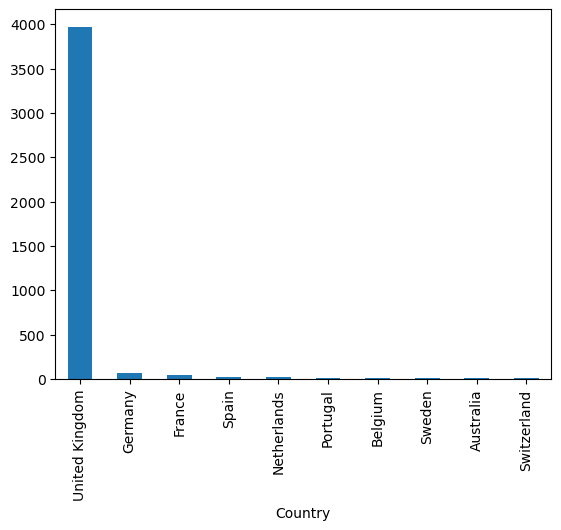

In [115]:
filtered_data = df[["Country","CustomerID"]].drop_duplicates()
filtered_data.Country.value_counts()[:10].plot(kind='bar')

### **Cell 8**  
**Description**:    
- Filter data for the United Kingdom.
- Selects relevant columns for RFM analysis.
- Adds a new column `TotalPrice`, calculated as `Quantity` × `Price`.



In [116]:
uk_data = df[df["Country"] == "United Kingdom"]
uk_data= uk_data[['Invoice','InvoiceDate','Quantity','Price','CustomerID']]
uk_data["TotalPrice"] = uk_data["Quantity"] * uk_data["Price"]
uk_data.shape,uk_data.head()

((364233, 6),
   Invoice         InvoiceDate  Quantity  Price  CustomerID  TotalPrice
 0  489434 2009-12-01 07:45:00        12   6.95       13085        83.4
 1  489434 2009-12-01 07:45:00        12   6.75       13085        81.0
 2  489434 2009-12-01 07:45:00        12   6.75       13085        81.0
 3  489434 2009-12-01 07:45:00        48   2.10       13085       100.8
 4  489434 2009-12-01 07:45:00        24   1.25       13085        30.0)

## **Stage 4: RFM Analysis**    
### **Cell 9**  
**Descreption**:
- Captures the present time using `datetime.now()` to calculate recency.
- Groups the data by CustomerID.
- Calculates: 
    - **Recency**: Days since the latest invoice date.
    - **Frequency**: Number of invoices per customer.
    - **Monetary**: Total revenue per customer.



In [122]:
present_time = datetime.now()
rfm = uk_data.groupby("CustomerID").agg({"InvoiceDate":lambda date :
(present_time- date.max()).days,
"Invoice": lambda num : len(num),
"TotalPrice" : lambda TotalPrice : TotalPrice.sum()})
rfm.columns = ["Recency","Frequency","Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,5258,33,372.86
12608,5133,16,415.79
12745,5215,22,723.85
12746,5269,17,254.55
12747,5098,153,5061.03


### **Cell 10**      
**Descreption**:
- Divides the `Recency`, `Frequency`, and `Monetary` metrics into quartiles using `qcut()`.
- Creates new columns for quartile ranks

In [125]:
rfm['r_quartile'] = pd.qcut(rfm['Recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['Frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['Monetary'], 4, ['4','3','2','1'])
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3969 entries, 12346 to 18287
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Recency     3969 non-null   int64   
 1   Frequency   3969 non-null   int64   
 2   Monetary    3969 non-null   float64 
 3   r_quartile  3969 non-null   category
 4   f_quartile  3969 non-null   category
 5   m_quartile  3969 non-null   category
dtypes: category(3), float64(1), int64(2)
memory usage: 120.8 KB


### **Cell 11**      
**Descreption**:
- Combines `Recency`, `Frequency`, and `Monetary` quartile values into an `RFM_Score`.
- Segments customers into High-, Mid-, and Low-Value categories based on their scores.

In [126]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+rfm.f_quartile.astype(str) +rfm.m_quartile.astype(str)
rfm["RFM_Score"] = rfm['RFM_Score'].astype(int)
segment_labels = ['A-Tier', 'B-Tier','C-Tier','D-Tier']
rfm['Value_Segment'] = pd.qcut(rfm['RFM_Score'], q=4, labels=segment_labels)
rfm.head()

,Recency,Frequency,Monetary,r_quartile,f_quartile,m_quartile,RFM_Score,Value_Segment
CustomerID,,,,,,,,
12346,5258,33,372.86,4,3,3,433,D-Tier
12608,5133,16,415.79,2,4,3,243,B-Tier
12745,5215,22,723.85,3,3,2,332,C-Tier
12746,5269,17,254.55,4,4,4,444,D-Tier
12747,5098,153,5061.03,1,1,1,111,A-Tier


## **Stage 4: Plotting the segmants**
### **Cell 12**
**Description**:
- Import Visualization libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

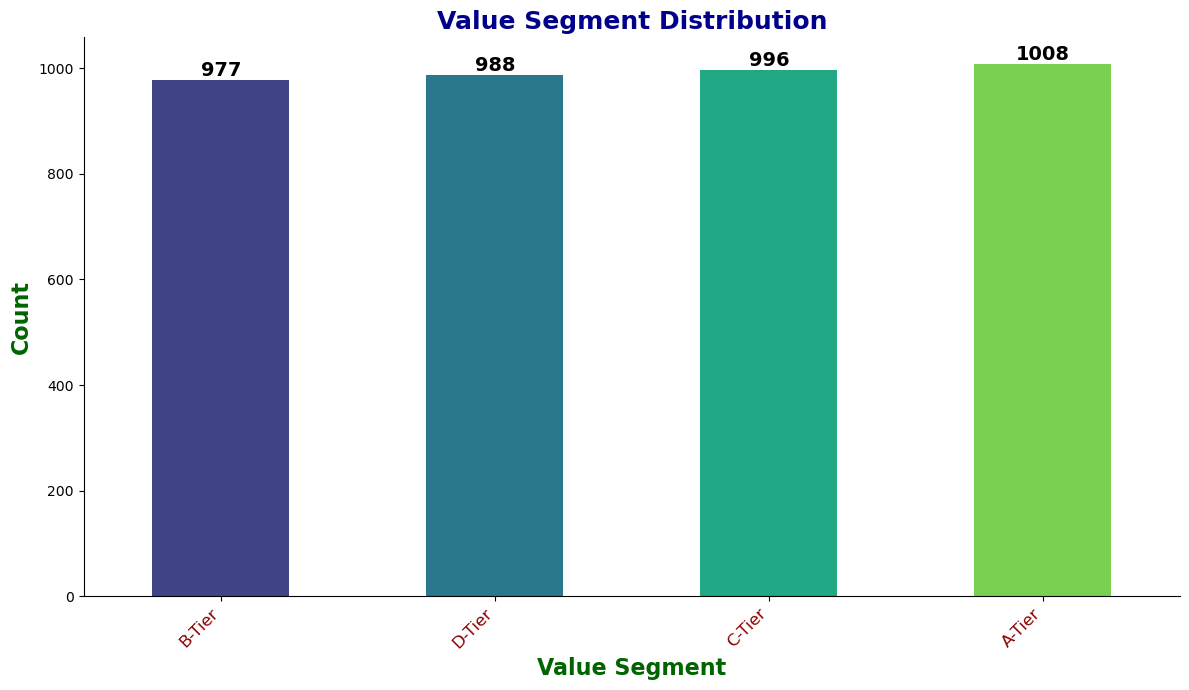

In [132]:
plt.figure(figsize=(12, 7)) 

# Plotting the bar chart
ax = rfm.Value_Segment.value_counts().sort_values().plot(kind='bar', color=sns.color_palette("viridis", 4))

# Customizing the plot title, axis labels, and grid
ax.set_title('Value Segment Distribution', fontsize=18, fontweight='bold', color='darkblue') 
ax.set_xlabel('Value Segment', fontsize=16, fontweight='bold', color='darkgreen') 
ax.set_ylabel('Count', fontsize=16, fontweight='bold', color='darkgreen')

# Adding annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=14, color='black', fontweight='bold')

# Adjusting the x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12, fontweight='medium', color='darkred')

# Adding a border and custom box styling
sns.despine()  # Remove top and right borders for a cleaner look
plt.tight_layout()  # Adjusts padding and margins for better display

plt.show()

## **Lambda functions**
### used in `cell 9` 
**Lambda functions in `Pandas` aggregations provide great flexibility by enabling you to**:

- Create custom calculations tailored to your needs
- Apply complex filtering within aggregations
- Execute multi-step transformations
- Incorporate conditional logic in your calculations
- Combine various operations within a single aggregation method